In [1]:
import numpy as np
import scipy as sp
from typing import Tuple
import time
import matplotlib.pyplot as plt

In [2]:
def get_elt_arrays(h:float,p:np.array,
                   q:np.array,f:np.array,
                   ne:int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Takes in a set of p,q,f vectors represnenting difussion, advection
    and forcing terms respectively. Returns a tuple of tensors representing
    the difussion matrices, mass matrices, and forcing vectors associated to 
    each element. 

    Parameters:
    -----------
    h: float
        Length of the element in the natural units of the problem.
    p: np.array
        Array of diffussion coefficients for each element.
    q: np.array
        Array of advection coefficients for each element. 
    f: np.array
        Array of forcing terms for each element. 
    ne: int
        Number of elements. 

    Returns:
    --------
    Kks : np.ndarray
        Tensor where the first index determines the element, and the
        next two correspond to the difussion matrix associated with that 
        element. 
    Mks: np.ndarray
        Tensor where the first index determines the element, and the
        next two correspond to the difussion matrix associated with that 
        element. 
    bks: np.ndarray
        Tensor where the first index determines the element, and the
        next one corresponds to the contribution due to the left and 
        right terms respectively. 

    """
    #Initialize elements 
    Kks = np.zeros((ne,2,2))
    Mks =  np.zeros((ne,2,2))
    bks = np.zeros((ne,2))
    #Form Difussion matrices
    Kks[:,0,0] = p/h
    Kks[:,0,1] = -p/h
    Kks[:,1,0] = -p/h
    Kks[:,1,1] = p/h
    #Form mass matrices
    Mks[:,0,0] = q*h/3
    Mks[:,0,1] = q*h/6
    Mks[:,1,0] = q*h/6
    Mks[:,1,1] = q*h/3
    #Form bks
    bks[:,0] = f*h/2
    bks[:,1] = f*h/2
    return Kks, Mks, bks

def get_timings(ne:int,
                              p:np.array,
                              q:np.array,
                              f:np.array,
                              a:float=0,
                              b:float=1, 
                              left_val:float=0,
                              right_val:float=0
                              )->float:
    """
    Get timings for the associated solver for a specific value
    of ne. 

    Parameters:
    ----------
    ne: int
        Number of elements. 
    p: np.array
        Array of diffussion coefficients for each element.
    q: np.array
        Array of advection coefficients for each element. 
    f: np.array
        Array of forcing terms for each element. 
    a: float
        Left end point of the interval the function is to be 
        defined on.
    b: float 
        Right end point of the interval the function is to be 
        defined on.
    left_val: float
        Value the function must take on the left end point.
    right_val: float
        Value the function must take on the right end point. 

    Returns:
    --------
    time_spent: float
        Time spent on solve. 
    
    """
    if b<=a:
        raise ValueError("b must be greater than a.")
    if not(p.ndim == 1 and q.ndim == 1 and f.ndim == 1):
        raise ValueError("p,q,h must all be vectors.")
    if not(len(p)==ne and len(q)==ne and len(f)==ne):
        raise ValueError("All arrays must be of length ne.")
    
    h = (b-a)/ne
    xx = np.arange(a,b+h,h)
    nvtx = len(xx)
    K = sp.sparse.lil_array((nvtx,nvtx))
    M = sp.sparse.lil_array((nvtx,nvtx))
    b = np.zeros(nvtx)
    Kks, Mks, bks = get_elt_arrays(h = h,
                                   p = p,
                                   q = q,
                                   f = f,
                                   ne = ne)

    for count in range(ne):
        K[count:count+2,count:count+2] += Kks[count,:,:]
        M[count:count+2,count:count+2] += Mks[count,:,:]
    b[:ne] = bks[:,0]
    b[-ne:] = bks[:,1]

    #Impose homogenous boundrary conditions
    A = K+M
    modified_b = b-left_val*A.getcol(0).todense().flatten()-right_val*A.getcol(-1).todense().flatten()
    A = A.todense()
    A_m = A[1:-1,1:-1]
    b_m = modified_b[1:-1]
    t1 = time.time_ns()
    u_int = np.linalg.solve(A_m,b_m)
    t2 = time.time_ns()
    time_spent = t2-t1
    return time_spent

def generate_log_num(n):
    out = np.zeros(n,dtype=int)
    out[0] = 4
    for k in range(1,n):
        out[k] = 2*out[k-1]
    return out

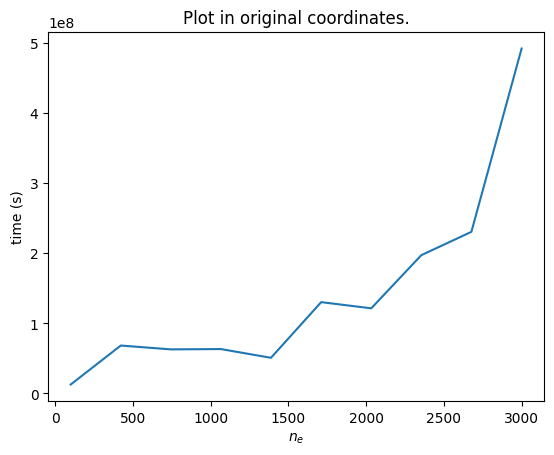

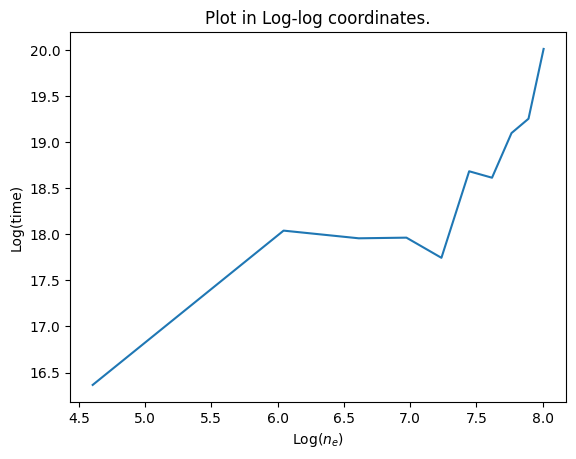

In [3]:
n = 10
ne_arr = np.linspace(100,3000,num=n,dtype=int)
times = np.zeros(n)
for count, ne in enumerate(ne_arr):
    p = np.ones(ne)
    q = np.zeros(ne)
    f = np.zeros(ne)
    times[count] = get_timings(ne=ne,
                                p=p,
                                q=q,
                                f=f)
    
log_times = np.log(times)
log_ne = np.log(ne_arr)

plt.plot(ne_arr,times)
plt.title("Plot in original coordinates.")
plt.xlabel("$n_e$")
plt.ylabel("time (s)")
plt.show()

plt.plot(log_ne,log_times)
plt.title("Plot in Log-log coordinates.")
plt.xlabel("Log($n_e$)")
plt.ylabel("Log(time)")
plt.show()